# Assessment Generator
- by Srivatsan Rangarajan

## Project Goal

I generated 500 questions using AI. I have done this 10 questions at a time to ensure a minimum threshold of quality.
Unfortunately, despite prompting each time and using the latest ChatGPT 4.5 version, all questions have the same issue: The correct answer is the longest. 

In an age where SMEs are encouraged to use AI to create assessments and skip the learning designer review stage, it's important that the AI generates good assessments that do not have obvious giveaways.

The goal of this project is to 

## Importing the dataset and preprocessing

In [6]:
import pandas as pd
import json

df = pd.read_csv("data/questions_dataset_final.csv")

df.head()

,Question Number,Question,Option A,Option B,Option C,Option D,Correct Option
0,1,Why does sweating cool the human body?,Sweat removes body toxins.,Sweat lubricates the skin cells.,Evaporation removes heat from skin.,Sweat reduces body blood pressure.,C
1,2,Why is crop rotation used in farming?,To maintain soil nutrients.,To attract more rainfall.,To eliminate insect pests.,To increase daylight exposure.,A
2,3,Why is it warmer in summer than winter?,The sun is closer in summer months.,Days are longer with direct sunlight.,Earth's rotation is slower in summer.,Atmosphere traps more heat in winter.,B
3,4,Why do birds migrate seasonally?,To follow ocean currents.,To find better nesting sites.,To escape predators entirely.,To avoid becoming nocturnal.,B
4,5,Why does bread dough rise with yeast?,Yeast releases oxygen bubbles.,Yeast strengthens flour fibers.,"Yeast ferments, producing gas.",Yeast causes flour expansion.,C


## Quick EDA to capture unwanted patterns

In [ ]:
%pip install matplotlib

In [ ]:
%pip install seaborn

C:\Users\sriva\AppData\Local\Temp\ipykernel_16692\937296933.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Correct Option"], palette="muted")


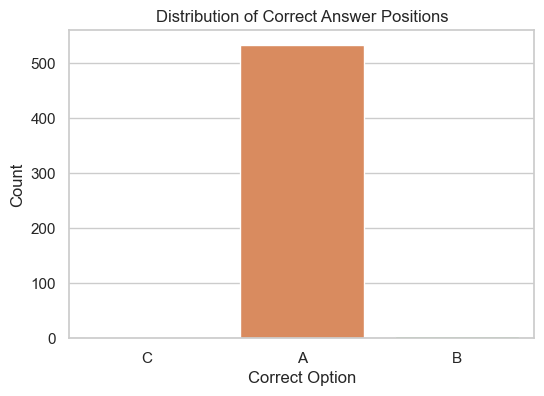

C:\Users\sriva\AppData\Local\Temp\ipykernel_16692\937296933.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Option", y="Length", data=df_melted, palette="Set2")


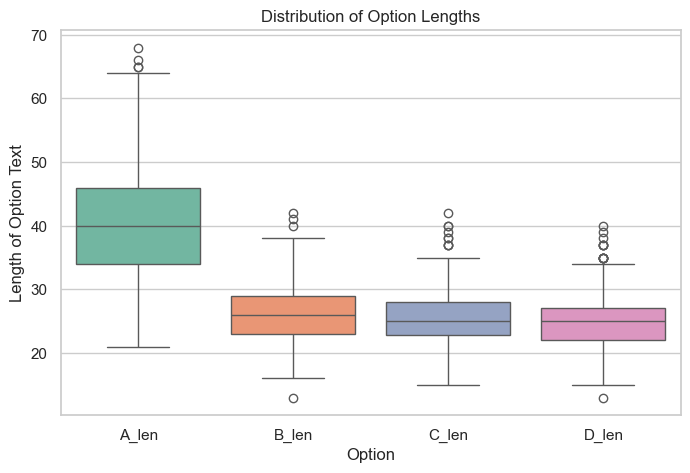

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Distribution of Correct Answers
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Correct Option"], palette="muted")
plt.title("Distribution of Correct Answer Positions")
plt.xlabel("Correct Option")
plt.ylabel("Count")
plt.show()

# 2. Length Distribution of All Options
# Calculate lengths of each option
df_lengths = df.copy()
df_lengths["A_len"] = df_lengths["Option A"].str.len()
df_lengths["B_len"] = df_lengths["Option B"].str.len()
df_lengths["C_len"] = df_lengths["Option C"].str.len()
df_lengths["D_len"] = df_lengths["Option D"].str.len()

# Melt into long format for comparison
df_melted = df_lengths.melt(id_vars=["Question Number"], 
                            value_vars=["A_len", "B_len", "C_len", "D_len"],
                            var_name="Option", value_name="Length")

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x="Option", y="Length", data=df_melted, palette="Set2")
plt.title("Distribution of Option Lengths")
plt.xlabel("Option")
plt.ylabel("Length of Option Text")
plt.show()

### EDA Observations

As you can see, we fall into the typical problems of using AI to generate assessments. Almost all answers are A and the correct answer is usually the longest.

To rectify this, I will randomize the correct options and use AI to balance the option length. (Ideally, we should be using quality human-generated assessments.)

In [17]:
import random


# Helper function to shuffle options
def shuffle_options(row):
    # Gather options into a list
    options = [
        ("A", row["Option A"].strip()),
        ("B", row["Option B"].strip()),
        ("C", row["Option C"].strip()),
        ("D", row["Option D"].strip())
    ]
    
    # Identify correct answer text
    original_correct = row[f"Option {row['Correct Option']}"].strip()
    
    # Shuffle the options
    random.shuffle(options)
    
    # Find new label for the correct answer
    for idx, (label, text) in enumerate(options):
        if text == original_correct:
            new_correct_label = chr(ord("A") + idx)
            break

    # Build new row
    shuffled_row = {
        "Question Number": row["Question Number"],
        "Question": row["Question"],
        "Option A": options[0][1],
        "Option B": options[1][1],
        "Option C": options[2][1],
        "Option D": options[3][1],
        "Correct Option": new_correct_label
    }
    return pd.Series(shuffled_row)

# Apply the shuffling
df_shuffled = df.apply(shuffle_options, axis=1)

# Save the shuffled dataset
df_shuffled.to_csv("data/questions_dataset_shuffled.csv", index=False)
print("✅ Options shuffled and correct answers updated!")


✅ Options shuffled and correct answers updated!


In [16]:
df_shuffled.head()

,Question Number,Question,Option A,Option B,Option C,Option D,Correct Option
0,1,Why does sweating cool the human body?,Sweat lubricates the skin cells.,Evaporation removes heat from skin.,Sweat removes body toxins.,Sweat reduces body blood pressure.,B
1,2,Why is crop rotation used in farming?,To increase daylight exposure.,To eliminate insect pests.,To maintain soil nutrients.,To attract more rainfall.,C
2,3,Why is it warmer in summer than winter?,Atmosphere traps more heat in winter.,Earth's rotation is slower in summer.,The sun is closer in summer months.,Days are longer with direct sunlight.,D
3,4,Why do birds migrate seasonally?,To find better nesting sites.,To follow ocean currents.,To avoid becoming nocturnal.,To escape predators entirely.,A
4,5,Why does bread dough rise with yeast?,Yeast releases oxygen bubbles.,Yeast causes flour expansion.,Yeast strengthens flour fibers.,"Yeast ferments, producing gas.",D


In [21]:
# Define a function to flag if the correct answer is longer than others by a given threshold
def is_correct_longest_by_chars_threshold(row, threshold=5):
    correct_label = row["Correct Option"]
    option_lens = {
        "A": len(row["Option A"]),
        "B": len(row["Option B"]),
        "C": len(row["Option C"]),
        "D": len(row["Option D"])
    }
    correct_len = option_lens[correct_label]
    distractor_lens = [v for k, v in option_lens.items() if k != correct_label]
    return correct_len - max(distractor_lens) >= threshold

# Apply the function with a default threshold of 5 characters
char_threshold = 10
df_flagged["correct_ans_longest"] = df_flagged.apply(
    lambda row: is_correct_longest_by_chars_threshold(row, threshold=char_threshold), axis=1
)

# Save to new file with threshold in filename
threshold_flagged_path = f"data/questions_dataset_flagged_{char_threshold}char_threshold.csv"
df_flagged.to_csv(threshold_flagged_path, index=False)

# Show preview
df_flagged[["Question", "Correct Option", "correct_ans_longest"]].head(10)


,Question,Correct Option,correct_ans_longest
0,Why does sweating cool the human body?,C,False
1,Why is crop rotation used in farming?,D,False
2,Why is it warmer in summer than winter?,B,False
3,Why do birds migrate seasonally?,D,False
4,Why does bread dough rise with yeast?,C,False
5,Why is fiber important in a diet?,C,False
6,Why are bees important to agriculture?,B,False
7,Why do shadows change during the day?,B,False
8,Why do bridges often have gaps?,C,False
9,Why do we refrigerate perishable foods?,B,False


In [11]:
import subprocess
import pandas as pd

# Load your flagged dataset
df = pd.read_csv("data/questions_dataset_flagged_5char_threshold.csv")

# Filter only rows where the correct answer is longest
flagged_rows = df[df["correct_ans_longest"] == True].copy().head(5)

# Helper function to call Ollama
def call_ollama(prompt, model="llama2:13b"):
    result = subprocess.run(
        ["ollama", "run", model],
        input=prompt.encode("utf-8"),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    return result.stdout.decode("utf-8")

# Loop over rows and populate new llama columns
for i, row in flagged_rows.iterrows():
    q = row["Question"]
    options = {
        "A": row["Option A"],
        "B": row["Option B"],
        "C": row["Option C"],
        "D": row["Option D"]
    }
    correct = row["Correct Option"]

    # Build prompt
    prompt = f"""You are helping prepare fair multiple-choice questions.
Some options are too long compared to others.
Please rephrase only the incorrect options (without changing the correct one) so that all four options are **similar in length and tone**. 
Avoid making any option noticeably longer or shorter than the others.


Question: {q}
A. {options['A']}
B. {options['B']}
C. {options['C']}
D. {options['D']}
Answer: {correct}

Return ONLY the updated incorrect options like this:
A. <revised>
B. <revised>
D. <revised>"""

    # Call Ollama
    output = call_ollama(prompt)

    # Start with original options
    for key in ["A", "B", "C", "D"]:
        flagged_rows.at[i, f"llama_option_{key.lower()}"] = options[key]

    # Replace only the options returned by LLaMA
    for line in output.strip().split("\n"):
        if line.strip()[:2] in ["A.", "B.", "C.", "D."]:
            label = line[0]
            text = line[2:].strip()
            flagged_rows.at[i, f"llama_option_{label.lower()}"] = text

# Save your preview set
flagged_rows.to_csv("llama_augmented_preview.csv", index=False)
print("✅ Done! Check 'llama_augmented_preview.csv' for side-by-side comparison.")


✅ Done! Check 'llama_augmented_preview.csv' for side-by-side comparison.


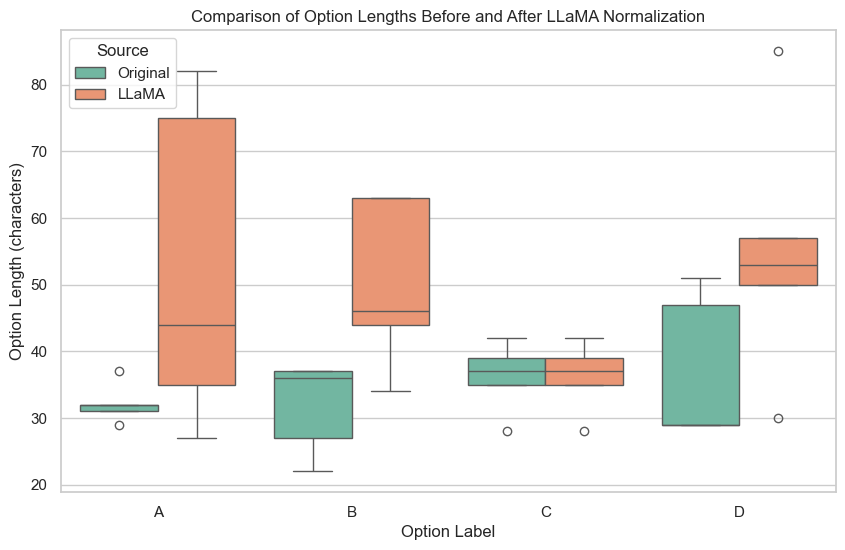

In [12]:
# Reload the re-uploaded preview CSV
df_llama_preview = pd.read_csv("llama_augmented_preview.csv")

# Add character lengths for original options
df_llama_preview["orig_A_len"] = df_llama_preview["Option A"].str.len()
df_llama_preview["orig_B_len"] = df_llama_preview["Option B"].str.len()
df_llama_preview["orig_C_len"] = df_llama_preview["Option C"].str.len()
df_llama_preview["orig_D_len"] = df_llama_preview["Option D"].str.len()

# Add character lengths for LLaMA options
df_llama_preview["llama_A_len"] = df_llama_preview["llama_option_a"].str.len()
df_llama_preview["llama_B_len"] = df_llama_preview["llama_option_b"].str.len()
df_llama_preview["llama_C_len"] = df_llama_preview["llama_option_c"].str.len()
df_llama_preview["llama_D_len"] = df_llama_preview["llama_option_d"].str.len()

# Melt for plotting
df_melted = pd.melt(
    df_llama_preview,
    id_vars=["Question"],
    value_vars=[
        "orig_A_len", "orig_B_len", "orig_C_len", "orig_D_len",
        "llama_A_len", "llama_B_len", "llama_C_len", "llama_D_len"
    ],
    var_name="Option_Type", value_name="Length"
)

# Extract source and option
df_melted["Source"] = df_melted["Option_Type"].apply(lambda x: "Original" if "orig" in x else "LLaMA")
df_melted["Option"] = df_melted["Option_Type"].str.extract(r'_(.?)_')

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="Option", y="Length", hue="Source", palette="Set2")
plt.title("Comparison of Option Lengths Before and After LLaMA Normalization")
plt.xlabel("Option Label")
plt.ylabel("Option Length (characters)")
plt.legend(title="Source")
plt.show()


In [14]:
import pandas as pd
import subprocess
import time

# Load dataset (must have "correct_ans_longest" column)
df = pd.read_csv("data/questions_dataset_flagged_10char_threshold.csv")

# Only flagged rows
df_flagged = df[df["correct_ans_longest"] == True].copy()

# Initialize llama columns
for col in ["llama_option_a", "llama_option_b", "llama_option_c", "llama_option_d"]:
    if col not in df_flagged.columns:
        df_flagged[col] = None


In [15]:
def build_prompt(row):
    options = {
        "A": row["Option A"],
        "B": row["Option B"],
        "C": row["Option C"],
        "D": row["Option D"]
    }
    correct = row["Correct Option"]
    q = row["Question"]
    
    return f"""You are helping prepare fair multiple-choice questions.

The following question has a correct answer that is noticeably longer than the others.

Please revise ONLY the incorrect options so that **all options are similar in length and tone**. Make sure not to make the correct answer the shortest. Keep incorrect options plausible, but not correct. Do not modify the correct answer.

Question: {q}
A. {options['A']}
B. {options['B']}
C. {options['C']}
D. {options['D']}
Answer: {correct}

Return ONLY the updated incorrect options like this:
A. <revised>
B. <revised>
D. <revised>"""


In [20]:
def call_ollama(prompt, model="llama2:13b"):
    result = subprocess.run(
        ["ollama", "run", model],
        input=prompt.encode("utf-8"),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    return result.stdout.decode("utf-8")

# Create or reload df_flagged
df_flagged = df[df["correct_ans_longest"] == True].copy().reset_index(drop=True)

# Optional: resume from file if needed
# df_flagged = pd.read_csv("data/llama_augmented_full.csv")

start_index = 0
batch_size = 10
output_path = "data/llama_augmented_full.csv"


for col in ["llama_option_a", "llama_option_b", "llama_option_c", "llama_option_d"]:
    if col not in df_flagged.columns:
        df_flagged[col] = None

for i in range(start_index, len(df_flagged)):
    if pd.notnull(df_flagged.at[i, "llama_option_a"]):
        continue  # Already processed

    row = df_flagged.loc[i]
    prompt = build_prompt(row)
    print(f"Processing Q{i}: {row['Question'][:50]}...")

    try:
        output = call_ollama(prompt)
        for line in output.strip().split("\n"):
            if line.strip()[:2] in ["A.", "B.", "C.", "D."]:
                label = line[0]
                text = line[2:].strip()
                df_flagged.at[i, f"llama_option_{label.lower()}"] = text
    except Exception as e:
        print(f"❌ Error at index {i}: {e}")
        continue

    # Save after every N rows
    if (i + 1) % batch_size == 0 or (i + 1) == len(df_flagged):
        print(f"💾 Saving checkpoint at row {i + 1}")
        df_flagged.to_csv(output_path, index=False)
        time.sleep(1)


Processing Q0: Why do planets orbit the sun in elliptical paths?...
Processing Q1: Why do astronauts wear pressurized suits in space?...
Processing Q2: Why do magnets attract iron?...
Processing Q3: Why is a rainbow curved?...
Processing Q4: Why do we yawn when tired?...
Processing Q5: Why does a compass point north?...
Processing Q6: Why is touch important for humans?...
Processing Q7: Why is glass transparent?...
Processing Q8: Why do onions make people cry?...
Processing Q9: Why do we stretch before exercising?...
💾 Saving checkpoint at row 10
Processing Q10: Why does fog form in the early morning?...
Processing Q11: Why do birds fly in V formation?...
Processing Q12: Why is iron important in the diet?...
Processing Q13: Why is photosynthesis important for the environmen...
Processing Q14: Why do camels store fat in their humps?...
Processing Q15: Why is the heart divided into four chambers?...
Processing Q16: Why does bread turn brown when toasted?...
Processing Q17: Why is the moo

In [21]:
df_flagged.head(10)

,Question Number,Question,Option A,Option B,Option C,Option D,Correct Option,correct_ans_longest,llama_option_a,llama_option_b,llama_option_c,llama_option_d
0,21,Why do planets orbit the sun in elliptical paths?,Planets bounce off other orbits.,Space-time twists all straight lines.,Solar flares push planets in loops.,Gravity and inertia interact to curve their mo...,D,True,Planets follow curved paths due to the combine...,The sun's gravitational pull causes planets to...,None,Magnetic fields within the planets direct thei...
1,35,Why do astronauts wear pressurized suits in sp...,To protect against vacuum and radiation.,To improve vision in darkness.,To absorb solar power.,To help them float evenly.,A,True,<revised> To shield themselves from harmful co...,<revised> To enhance their sense of balance an...,None,<revised> To conserve energy by reducing the n...
2,40,Why do magnets attract iron?,Iron atoms align with magnetic fields.,Iron holds magnetic water.,Magnets contain iron inside.,Iron repels gravity.,A,True,Iron atoms become temporarily magnetized when ...,"Magnets cause iron molecules to vibrate, creat...",None,Iron objects have a subtle magnetic charge tha...
3,64,Why is a rainbow curved?,Rain falls in circular motion.,Light bends and reflects in water droplets.,Wind shapes the sunlight.,Clouds push colors into arcs.,B,True,"Rain falls in a continuous, rather than circul...",Light bends and reflects off of tiny particles...,None,"Clouds compress and distort sunlight, creating..."
4,65,Why do we yawn when tired?,To block out noise.,To lower heart rate.,To warm the throat.,To increase oxygen to the brain.,D,True,To relieve stress and anxiety.,To regulate body temperature.,None,To improve digestion and gut health.
5,67,Why does a compass point north?,It is pulled by the sun.,It aligns with Earth’s magnetic field.,It detects sound waves.,It tracks ocean currents.,B,True,It is attracted by a mysterious force that onl...,It has a special connection to the Earth's ene...,None,It uses some kind of ancient knowledge to dete...
6,76,Why is touch important for humans?,It helps detect pressure and temperature.,It keeps bones flexible.,It spreads body heat.,It directs muscle growth.,A,True,It helps regulate our sense of touch and allow...,It plays a crucial role in our ability to move...,None,It helps maintain proper body posture and alig...
7,77,Why is glass transparent?,It traps only red light.,It lacks a reflective surface.,Light passes through its uniform structure.,Its molecules are cold.,C,True,It absorbs all colors except red.,Its surface is too smooth for light to reflect.,None,Its molecules are too small for light to inter...
8,79,Why do onions make people cry?,They cool the face rapidly.,Their texture is sharp.,Their color is too bright.,They release a gas that irritates eyes.,D,True,They contain a chemical that irritates the eyes.,Their strong smell can cause eye watering.,None,The way they're cut or chopped can release a g...
9,81,Why do we stretch before exercising?,To slow down heart rate.,To build muscle mass.,To reduce injury and improve flexibility.,To increase body temperature.,C,True,To improve overall physical fitness and endura...,To enhance mental focus and concentration.,None,To increase metabolism and burn more calories.


Llama-generated assessment before fine-tuning

In [6]:
import subprocess

def call_ollama(prompt, model="llama2:13b"):
    result = subprocess.run(
        ["ollama", "run", model],
        input=prompt.encode("utf-8"),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    return result.stdout.decode("utf-8")

# Basic test prompt
test_prompt = "create a question on machine learning mcq understand"

response = call_ollama(test_prompt)
print(response)



Sure, here's a multiple choice question (MCQ) on machine learning:

Question:

Which of the following is NOT a type of supervised learning algorithm?

A) Regression
B) Classification
C) Clustering
D) Unsupervised learning

Choose the correct answer from the options above.

Explanation:

Regression, classification, and clustering are all types of supervised learning algorithms. These algorithms learn from labeled data, where the target variable is known. On the other hand, unsupervised learning algorithms learn from unlabeled data, and try to identify patterns or structure in the data without any prior knowledge of the target variable. Therefore, option D (Unsupervised learning) is not a type of supervised learning algorithm.

I hope this helps! Let me know if you have any other questions.


